In [1]:
import os
import sys
import math
import operator
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import gridmap_config as c

from IPython.display import display, HTML
from tabulate import tabulate
from shapely.geometry import Polygon, Point
from math import sqrt
from shapely.affinity import translate

In [2]:
polys = c.kenya_counties_msSimplified
polys = c.USA_extraSimp
#keep_flds = ['County', 'CID'] #Kenya
keep_flds = ['NAME_1', 'short_name'] #USA
os.path.isfile(polys)

True

In [3]:
admin = gpd.read_file(polys).to_crs({'init': 'epsg:5070'})
admin['short_name'] = admin['HASC_1'].str.split('.').str[1]
admin = admin.sort_values(by='NAME_1').reset_index(drop=True)
admin = admin.rename(columns={'geometry': 'geom_poly'}).set_geometry('geom_poly')
keep_flds.append(admin.geometry.name)
del_flds = [x for x in list(admin) if x not in keep_flds]
admin.drop(columns=del_flds, inplace=True)
admin.head(3)

,NAME_1,geom_poly,short_name
0,Alabama,"POLYGON ((728281.9053291343 842366.7899221318,...",AL
1,Arizona,POLYGON ((-1733371.378979061 1243103.444279246...,AZ
2,Arkansas,"POLYGON ((181441.7024997548 1107458.717934108,...",AR


In [4]:
def display_point_labels(gdf, label_col, fs=10, c='blue'):
    texts = []
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf[label_col]):
        texts.append(plt.text(x, y, label, fontsize=fs, color=c))

def add_centroid_geom(gdf):
    gdf['geom_centroid'] = gdf.centroid
    return gdf

def add_convexhull_geom(gdf):
    gdf['geom_convexhull'] = gdf.convex_hull
    return gdf

def dissolve_polygons(gdf):
    gdf['dissolve_col'] = 1
    gdf_dissolve = gdf.dissolve(by='dissolve_col')
    gdf_dissolve['geom_exterior'] = Polygon(gdf_dissolve.exterior[1])
    gdf_dissolve = gdf_dissolve.set_geometry('geom_exterior')
    gdf_dissolve['geom_centroid'] = gdf_dissolve.centroid
    return gdf_dissolve

admin = add_centroid_geom(admin)
admin = add_convexhull_geom(admin)
admin_hulls_dissolved = dissolve_polygons(admin.set_geometry('geom_convexhull'))

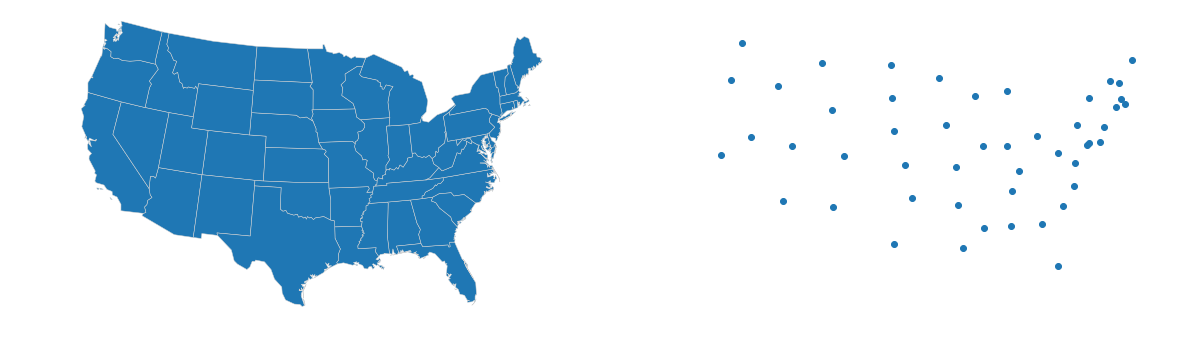

In [5]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, edgecolor='lightgrey')

# Plot on axis 2 (right)
ax2.set_axis_off()
admin.set_geometry('geom_centroid').plot(ax=ax2)

plt.show()

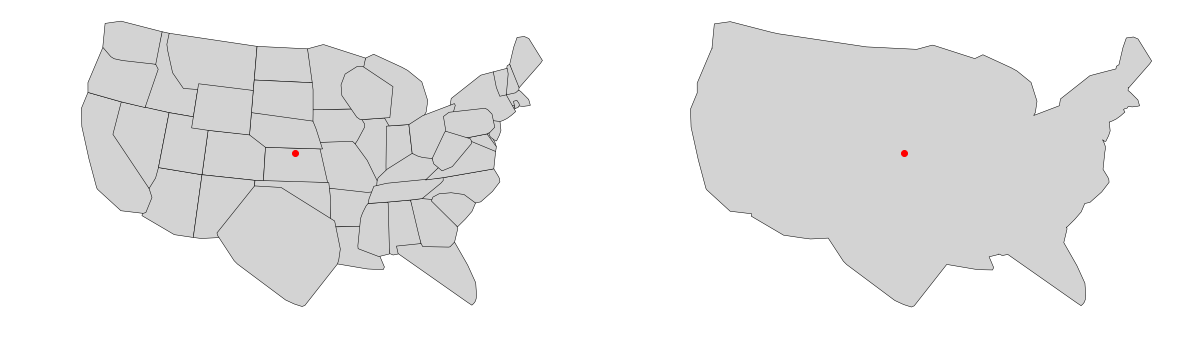

In [6]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_convexhull').plot(ax=ax1, linewidth=0.5, edgecolor='black', color='lightgrey')
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax1, color='red')

# Plot on axis 2 (right)
ax2.set_axis_off()
admin_hulls_dissolved.plot(ax=ax2, linewidth=0.5, edgecolor='black', color='lightgrey')
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax2, color='red')

plt.show()

In [7]:
def round_dict_vals(dictionary, places=10):
    for k, v in dictionary.items():
        dictionary[k] = float(round(dictionary[k], places))
    return dictionary

def get_bounding_coordinates(gpd, round_nums=True):
    tb = gpd.total_bounds
    total_bounds = {'minx': tb[0],
                    'miny': tb[1],
                    'maxx': tb[2],
                    'maxy': tb[3],
                    'rangex': abs(tb[0] - tb[2]),
                    'rangey': abs(tb[1] - tb[3])}
    if round_nums:
        total_bounds = round_dict_vals(total_bounds)
    
    return total_bounds

def build_bounding_polygon(extent, crs):
    BL = (extent['minx'], extent['miny'])
    BR = (extent['maxx'], extent['miny'])
    TR = (extent['maxx'], extent['maxy'])
    TL = (extent['minx'], extent['maxy'])
    corners = [BL, BR, TR, TL]
    rectangle = gpd.GeoDataFrame(pd.DataFrame({'geometry': [Polygon(corners)]}), geometry='geometry', crs=crs)
    
    return rectangle
    
bbox = get_bounding_coordinates(admin.set_geometry('geom_poly'))
bbox_gdf = build_bounding_polygon(bbox, admin.crs)
bbox

{'minx': -2354015.2549957507,
 'miny': 311383.0413461132,
 'maxx': 2258357.676058443,
 'maxy': 3165734.0597565253,
 'rangex': 4612372.9310541935,
 'rangey': 2854351.018410412}

In [8]:
def displace_vertex(x, y, length, angle):
    '''
    calculates new point up to a given distance away
    from original point. All values should be provided
    in meters

    point = (x,y)
    '''
    #The number pi
    PI = 3.1415926535

    #Convert the random angle from degrees to radians
    angle_radian = (angle) * (PI/180)

    #Generate the offset by applying trig formulas (law of cosines) 
    #using the distance as the hypotenuse solving for the other sides
    xOffset = math.sin(angle_radian) * length
    yOffset = math.cos(angle_radian) * length

    #Add the offset to the orginal coordinate
    new_x = x + xOffset
    new_y = y + yOffset

    return (new_x, new_y) 

def build_hexagon(x, y, length, bearing):
    pts = [(x,y)]
    
    for pt in range(0,5):
        x, y = displace_vertex(x, y, length, bearing)
        bearing += 60
        pts.append((x,y))
    hex_poly = Polygon(pts)
    return hex_poly

def tesselate_hexagons_translate(bb, hull, length, x_offset_factor, y_offset_factor, flat='up'):
    hexes = []
    x_offset_seed = x_offset_factor * length
    y_offset_seed = y_offset_factor * length
    
    # flat='up' means flat sides are up and down
    # flat='side' means flat sides are on the sides
    if flat=='up':
        bearing = 30
        next_start_pt_idx = 3
    elif flat=='side':
        bearing = 0
        next_start_pt_idx = 4
    else:
        raise Exception('Acceptable parameters for flat: \'up\' and \'side\'')
    
    hexagon_seed = build_hexagon(bb['minx'] + x_offset_seed, bb['miny'] + y_offset_seed, length, bearing)
    hexagon = hexagon_seed
    
    row=1
    shift = 1
    xy_inside_bbox = True
    while xy_inside_bbox:
        hex_gdf = gpd.GeoDataFrame(pd.DataFrame({'geom_poly': [hexagon]}), geometry='geom_poly')
        centroid = hexagon.centroid

        x_inside = ((centroid.x >= bb['minx'] - abs(x_offset_seed)) and
                    (centroid.x <= bb['maxx'] + abs(x_offset_seed)))
        y_inside = ((centroid.y >= bb['miny'] - abs(y_offset_seed)) and
                    (centroid.y <= bb['maxy'] + abs(y_offset_seed)))
        
        if hull.intersects(centroid):
            hexes += [hex_gdf]

        if x_inside and y_inside:
            if flat == 'up':     
                move_x = 3 * length
            elif flat == 'side': 
                move_x = sqrt(3) * length     
            move_y = 0
                
        elif not x_inside and y_inside:
            hexagon = hexagon_seed
            if flat == 'up':
                if row%2 == 0: #Every other row
                    move_y = (sqrt(3) * length * shift) + y_offset_seed
                    move_x = 0 + x_offset_seed
                    shift+=1 
                else:
                    move_y = (((sqrt(3) * length) * shift) - (0.5 * sqrt(3) * length))  + y_offset_seed
                    move_x = (length * 1.5) + x_offset_seed
           
            elif flat == 'side':
                if row%2 == 0: #Every other row
                    move_y = 1.5 * length * row
                    move_x = 0#  + x_offset_seed
                else:
                    move_y = 1.5 * length * row
                    move_x = -((0.5 * sqrt(3) * length))# + x_offset_seed)
            row+=1
            
        else:
            xy_inside_bbox = False
 
        hexagon = translate(hexagon, xoff=move_x, yoff=move_y)

    
    hexes_gdf = gpd.GeoDataFrame(pd.concat(hexes, ignore_index=True, sort=False), crs=hexes[0].crs, geometry='geom_poly')
    hexes_gdf = add_centroid_geom(hexes_gdf)
    return hexes_gdf
    
def iterate_size(adm, bb, flat, x_offset_factor, y_offset_factor, len_factor, iter_factor): #x_offset_factor should be between -1 and 1
    length = max(bb['rangex'], bb['rangey']) / (len(adm) * len_factor)
    print(length)
    
    hex_count = len(adm) + 1
    i = 1
    while hex_count > len(adm):
        hexagons = tesselate_hexagons_translate(bb=bbox, 
                                                hull=admin_hulls_dissolved['geom_convexhull'][1], 
                                                length=length,
                                                x_offset_factor=x_offset_factor,
                                                y_offset_factor=y_offset_factor,
                                                flat=flat)
        hex_count = len(hexagons)
        
        print('Iteration: {}  hexagons: {}  length: {}'.format(i, hex_count, length))
        length = length * iter_factor
        i+=1

    return hexagons

xofac1 = 0.2
yofac1 = 0.2
xofac2 = -1
yofac2 = 0
lfac   = 0.38
ifac   = 1.0009
hexagons_up = iterate_size(admin, bbox, flat='up', 
                           x_offset_factor=xofac1, y_offset_factor=yofac1, 
                           len_factor=lfac, iter_factor=ifac)
hexagons_side = iterate_size(admin, bbox, flat='side', 
                             x_offset_factor=xofac2, y_offset_factor=yofac2, 
                             len_factor=lfac, iter_factor=ifac)
#hexagons_side = iterate_size(admin, bbox, flat='side', iter_factor=1.0015)

247710.68373008555
Iteration: 1  hexagons: 53  length: 247710.68373008555
Iteration: 2  hexagons: 54  length: 247933.6233454426
Iteration: 3  hexagons: 54  length: 248156.7636064535
Iteration: 4  hexagons: 54  length: 248380.10469369928
Iteration: 5  hexagons: 54  length: 248603.6467879236
Iteration: 6  hexagons: 54  length: 248827.3900700327
Iteration: 7  hexagons: 54  length: 249051.3347210957
Iteration: 8  hexagons: 54  length: 249275.48092234466
Iteration: 9  hexagons: 54  length: 249499.82885517474
Iteration: 10  hexagons: 54  length: 249724.37870114436
Iteration: 11  hexagons: 54  length: 249949.13064197538
Iteration: 12  hexagons: 54  length: 250174.08485955314
Iteration: 13  hexagons: 52  length: 250399.2415359267
Iteration: 14  hexagons: 52  length: 250624.600853309
Iteration: 15  hexagons: 52  length: 250850.16299407696
Iteration: 16  hexagons: 52  length: 251075.9281407716
Iteration: 17  hexagons: 51  length: 251301.89647609828
Iteration: 18  hexagons: 50  length: 251528.068

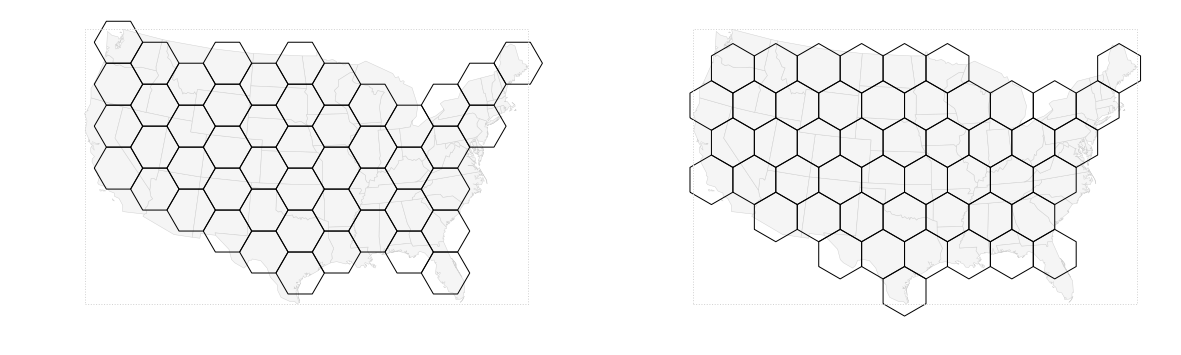

In [9]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
hexagons_up.plot(ax=ax1, edgecolor='black', facecolor="none")
bbox_gdf.plot(ax=ax1, facecolor="none", edgecolor='lightgrey', linestyle=':')
#pt.plot(ax=ax1, color='red')

# Plot on axis 2 (left)
ax2.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax2, linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
hexagons_side.plot(ax=ax2, edgecolor='black', facecolor="none")
bbox_gdf.plot(ax=ax2, facecolor="none", edgecolor='lightgrey', linestyle=':')

plt.show()

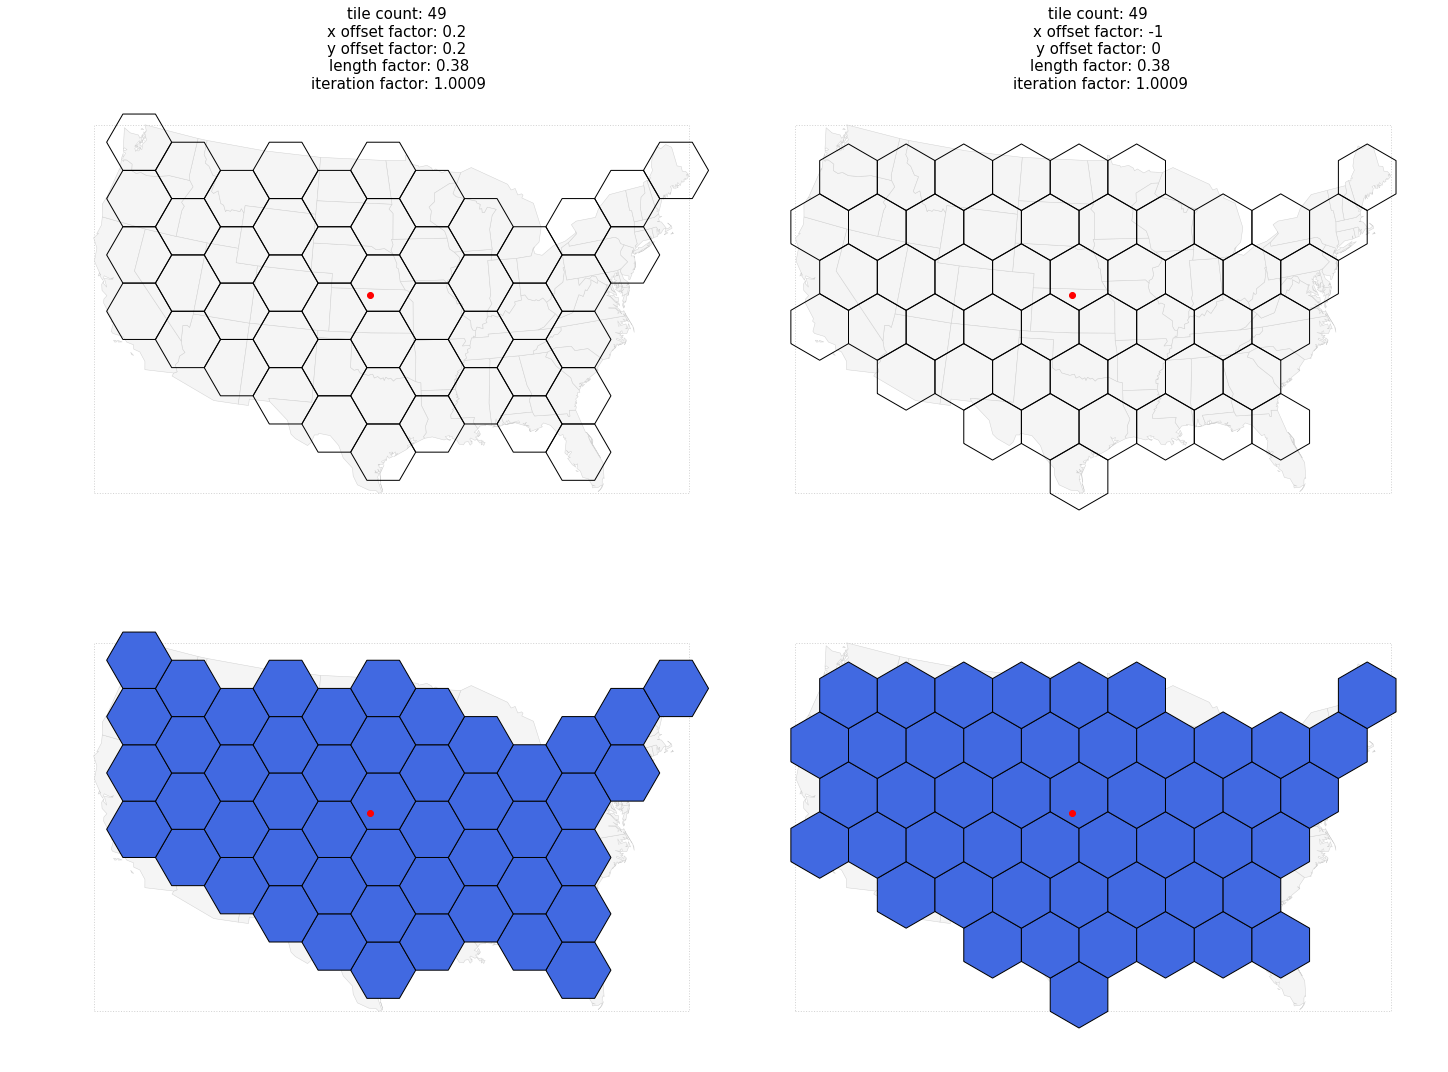

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(20, 15), sharex=True, sharey=True)

# Plot on axis 1 (top left)
ax[0,0].set_title('tile count: {} \nx offset factor: {} \ny offset factor: {} \nlength factor: {}\niteration factor: {}'.format(len(hexagons_up), xofac1, yofac1, lfac, ifac), 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax[0,0].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[0,0], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[0,0], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_up.plot(ax=ax[0,0], edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[0,0], color='red')

# Plot on axis 2 (top right)
ax[0,1].set_title('tile count: {} \nx offset factor: {} \ny offset factor: {} \nlength factor: {}\niteration factor: {}'.format(len(hexagons_up), xofac2, yofac2, lfac, ifac), 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax[0,1].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[0,1], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[0,1], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_side.plot(ax=ax[0,1], edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[0,1], color='red')

# Plot on axis 3 (bottom left)
ax[1,0].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[1,0], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[1,0], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_up.plot(ax=ax[1,0], edgecolor='black', facecolor="royalblue")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[1,0], color='red')

# Plot on axis 4 (bottom right)
ax[1,1].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[1,1], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[1,1], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_side.plot(ax=ax[1,1], edgecolor='black', facecolor="royalblue")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[1,1], color='red')

plt.show()

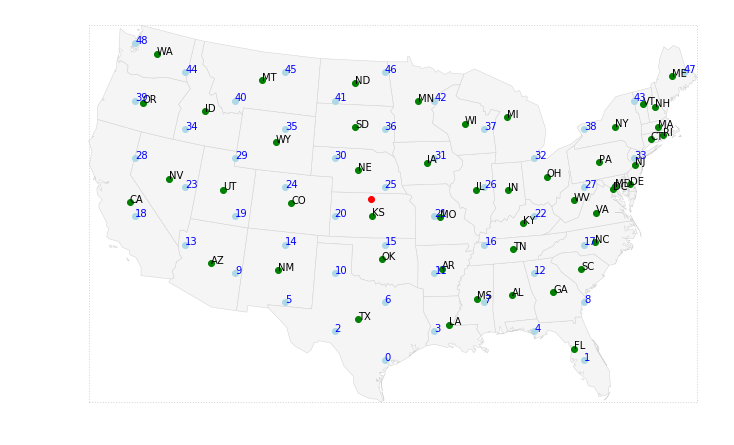

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
#hexagons_up.plot(ax=ax, edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax, color='red')
hexagons_up.set_geometry('geom_centroid').plot(ax=ax, color='lightblue')
display_point_labels(admin.set_geometry('geom_centroid'), 'short_name', c='black')
hexagons_up['idx'] = hexagons_up.index
display_point_labels(hexagons_up.set_geometry('geom_centroid'), 'idx')

admin.set_geometry('geom_centroid').plot(ax=ax, color='green')

In [28]:
def add_field_dist_to_outline_centroid(centers, centroid, idx_col):
    distances = {}
    centroid_pt = centroid['geom_centroid'][1] #Get Shapely point geom from geodataframe
    
    try:
        centers.drop(columns=['dist_to_centroid', 'join_order'], inplace=True)
    except:
        pass
        
    for i, row in centers.iterrows():
        pt = row['geom_centroid']
        idx = row[idx_col] 
        distance = pt.distance(centroid_pt)
        #print('{}  {}  {}'.format(i, tile_idx, distance))
        distances[idx] = distance
    distances_dict = dict(sorted(distances.items(), key=operator.itemgetter(1), reverse=True))
    distances_df = pd.DataFrame(list(distances_dict.items()), columns=[idx_col, 'dist_to_centroid'])
    distances_df['join_order'] = distances_df.index
    centers = centers.join(distances_df.set_index(idx_col), 
                                     on=idx_col).sort_values(by=['join_order']).reset_index(drop=True)

    return centers

def calc_dist_tile_to_admins(tile_centers, admin_centers):
    distances = {}
    
    for idx1, tile_row in tile_centers.iterrows():
        tile_pt = tile_row['geom_centroid']
        tile_idx = tile_row['idx']
        distances[tile_idx] = {}
        
        for idx2, admin_row in admin_centers.iterrows():
            admin_pt = admin_row['geom_centroid']
            admin_idx = admin_row['short_name']
            distance = tile_pt.distance(admin_pt)
            #print(distance)
            
            distances[tile_idx][admin_idx] = distance 

    return distances

def build_admin_tile_distance_df(admin_centers, tile_centers):
    cols = ['admin', 'tile', 'distance'] 
    df_dist = pd.DataFrame(columns=cols)
    
    for idx1, admin_row in admin_centers.iterrows():
        admin_pt = admin_row['geom_centroid']
        admin_idx = admin_row['short_name']
        
        for idx2, tile_row in tile_centers.iterrows():
            tile_pt = tile_row['geom_centroid']
            tile_idx = tile_row['idx']
            distance = tile_pt.distance(admin_pt)
            #print(distance)
            
            df_tmp = pd.DataFrame([[admin_idx, tile_idx, distance]], columns=cols)
            df_dist = df_dist.append(df_tmp, ignore_index=True)
            
    return df_dist
    
#def build_dist_to_centroid_df(admin_centers, tile_centers, center, which=[]):
    
distance_df = build_admin_tile_distance_df(admin, hexagons_up)
hexagons_up = add_field_dist_to_outline_centroid(hexagons_up, admin_hulls_dissolved, 'idx')
admin = add_field_dist_to_outline_centroid(admin, admin_hulls_dissolved, 'short_name')
#print(admin[['short_name', 'join_order']].head(5))
#print(hexagons_up[['idx', 'join_order']].head(5))

for i, row in admin[['short_name', 'join_order']].iterrows():
    print('{} {}'.format(row['short_name'], row['join_order']))
    if i>5: break
print('\n')
for i, row in hexagons_up[['idx', 'join_order']].iterrows():
    print('{} {}'.format(row['idx'], row['join_order']))
    if i>5: break



ME 0
NH 1
RI 2
MA 3
VT 4
CT 5
NJ 6


47 0
48 1
43 2
1 3
33 4
39 5
28 6


In [70]:
def match_one_to_another(admin_centers, tile_centers, dist_df, order_defined_by):
    cols = ['admin', 'tile'] 
    df_match = pd.DataFrame(columns=cols)
    
    if order_defined_by == 'admin':
        for i, row in admin_centers[['short_name', 'join_order']].iterrows():
            admin_id = row['short_name']
            df = dist_df.loc[dist_df['admin'] == admin_id]
            tile_id = df.loc[df.groupby('admin')['distance'].idxmin()]['tile'].values[0]
            #print('{} to {}'.format(row['short_name'], tile_id))
            dist_df = dist_df[dist_df['tile'] != tile_id]

            df_tmp = pd.DataFrame([[admin_id, tile_id]], columns=cols)
            df_match = df_match.append(df_tmp, ignore_index=True)

    start here - extract row for each state with min distance, get tile number, 
    then delete tile number from remaining dist_df

            #print(df.sort_values(by=['distance']))
            #if i>10: break
    return df_match
    
match_one_to_another(admin, hexagons_up, distance_df, 'admin')
#distance_df.head(5)   
#df.groupby('admin')['distance'].min()
#print(df.loc[df.groupby('tile')['distance'].idxmin()].shape)

#df.loc[df.groupby('admin')['distance'].idxmin()].sort_values(by=['distance']).reset_index(drop=True)

,admin,tile
0,ME,47
1,NH,43
2,RI,33
3,MA,38
4,VT,27
5,CT,32
6,NJ,17
7,DE,22
8,WA,48
9,NY,37


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_up.plot(ax=ax, edgecolor='black', facecolor="none")
#admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax, color='red')
#hexagons_up.set_geometry('geom_centroid').plot(ax=ax, color='lightblue')
#display_point_labels(admin.set_geometry('geom_centroid'), 'short_name', c='black')
hexagons_up['idx'] = hexagons_up.index
display_point_labels(hexagons_up.set_geometry('geom_centroid'), 'matched_admin', c='black')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_up.plot(ax=ax, edgecolor='black', facecolor="none")
#admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax, color='red')
#hexagons_up.set_geometry('geom_centroid').plot(ax=ax, color='lightblue')
#display_point_labels(admin.set_geometry('geom_centroid'), 'short_name', c='black')
hexagons_up['idx'] = hexagons_up.index
display_point_labels(hexagons_up.set_geometry('geom_centroid'), 'join_order', c='black')